In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [3]:
import tensorflow as tf
print("Num GPUs:", len(tf.config.list_physical_devices("GPU")))


Num GPUs: 1


## Loads images from subfolders, where each subfolder name is treated as a class label.

* Converts each image into a numerical tensor (multi-dimensional array) so it can be used by the model.

* Resizes all images to 256x256

* Returns a tf.data.Dataset of (image, label) pairs, batched by 32.

* shuffle=True ensures the images are randomly ordered for training

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
"PlantVillage",
shuffle=True,
image_size = (IMAGE_SIZE, IMAGE_SIZE) ,
batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


2025-05-23 18:47:10.762298: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-05-23 18:47:10.762331: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-05-23 18:47:10.762340: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-05-23 18:47:10.762374: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-23 18:47:10.762397: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
dataset.class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

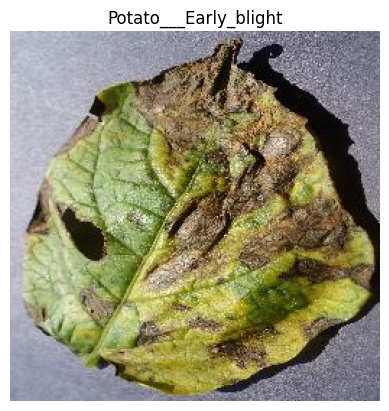

(256, 256, 3)


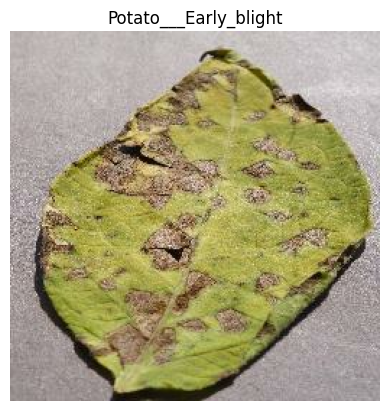

(256, 256, 3)


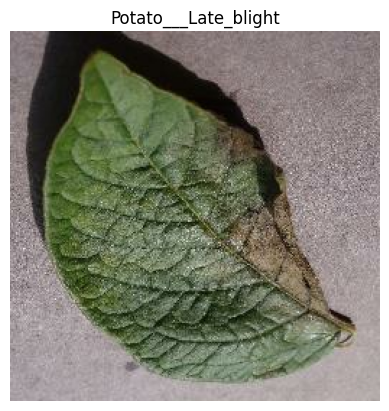

(256, 256, 3)


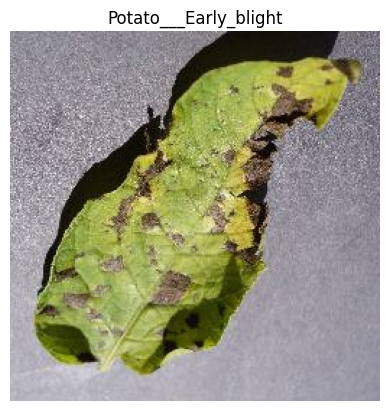

(256, 256, 3)


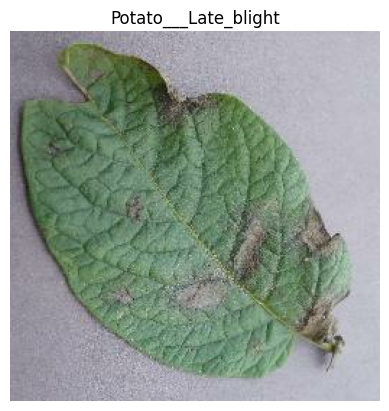

(256, 256, 3)


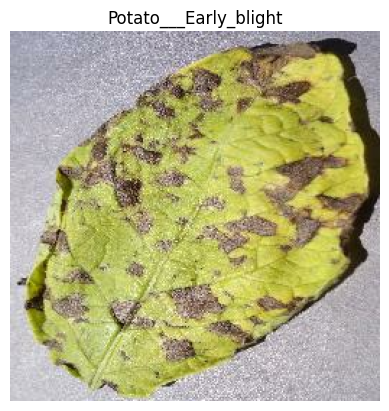

(256, 256, 3)


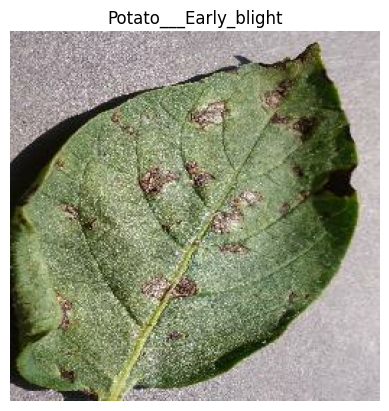

(256, 256, 3)


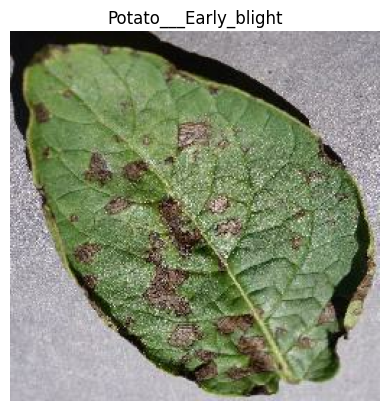

(256, 256, 3)


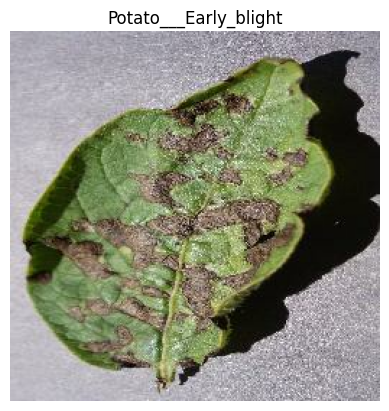

(256, 256, 3)


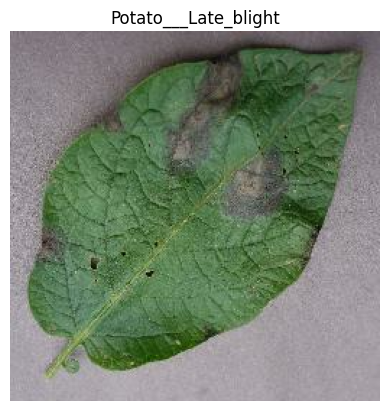

(256, 256, 3)


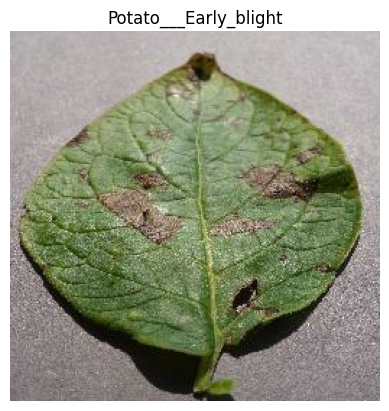

(256, 256, 3)


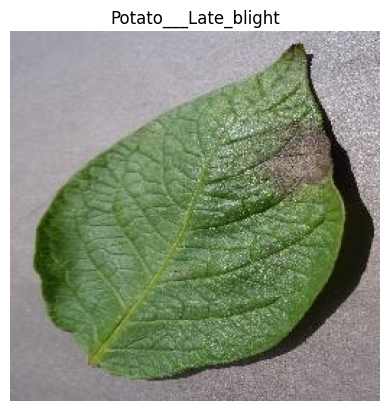

(256, 256, 3)


2025-05-23 18:47:11.785436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(dataset.class_names[label_batch[i]])
        plt.show()  # Needed to display each image
        print(image_batch[i].shape)  # Print the shape for each image


In [7]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [8]:
train_ds= dataset.take(54)
len(train_ds)

54

In [9]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [10]:
val_ds = test_ds.take(6)
len (val_ds)

6

In [11]:
test_ds = test_ds.skip(6)
len(test_ds)

8

* This function splits a TensorFlow dataset into training, validation, and test subsets.

* You can control the percentage split via parameters (train_split, val_split, test_split).

* Optionally shuffles the dataset before splitting, using a buffer of shuffle_size.

* Returns three datasets: train_ds, val_ds, and test_ds, each representing a portion of the original dataset

In [12]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size = 1000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size). take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [13]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [14]:
len(train_ds)

54

In [15]:
len(val_ds)

6

In [16]:
len(test_ds)

8

## cache()

* Stores the dataset in memory after the first epoch.

* Greatly speeds up data access in subsequent epochs.

* Especially useful when the dataset fits in memory.

## shuffle(1000)

* Randomly mixes the order of elements using a buffer of 1000.

* Helps improve model generalization by preventing it from seeing data in the same order.

* Should typically be used only on the training set — no need to shuffle validation/test data.

## prefetch(tf.data.AUTOTUNE)

* Allows the pipeline to fetch the next batch while the current batch is being processed by the model.

* AUTOTUNE lets TensorFlow choose the optimal number of batches to prefetch.

* Reduces GPU/CPU idle time, speeding up training.



In [17]:
train_ds = train_ds.cache().shuffle(1000, reshuffle_each_iteration=True).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Data Augmentation

In [18]:
from tensorflow.keras.layers import Resizing, Rescaling

resize_and_rescale = tf.keras.Sequential([
    Resizing(IMAGE_SIZE, IMAGE_SIZE),
    Rescaling(1/255)
])


In [19]:
from tensorflow.keras.layers import (
    RandomFlip, RandomRotation, RandomZoom,
    RandomContrast, RandomTranslation, RandomBrightness
)
from tensorflow.keras import Sequential

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),])


# CNN

In [20]:
input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model =  models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape = input_shape)

/Users/rishishukla/Desktop/potato-disease/tf-metal/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(
optimizer= 'adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy']
)
EPOCHS = 45

In [23]:
history = model.fit(train_ds,epochs= EPOCHS,batch_size=BATCH_SIZE,verbose=1,validation_data=val_ds)

Epoch 1/45


2025-05-23 18:47:12.810240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 282ms/step - accuracy: 0.4642 - loss: 0.9348 - val_accuracy: 0.7135 - val_loss: 0.8687
Epoch 2/45
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 302ms/step - accuracy: 0.6807 - loss: 0.7656 - val_accuracy: 0.8021 - val_loss: 0.4968
Epoch 3/45
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 291ms/step - accuracy: 0.7396 - loss: 0.6789 - val_accuracy: 0.8281 - val_loss: 0.4298
Epoch 4/45
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 293ms/step - accuracy: 0.8258 - loss: 0.4603 - val_accuracy: 0.8646 - val_loss: 0.3865
Epoch 5/45
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 289ms/step - accuracy: 0.8582 - loss: 0.3910 - val_accuracy: 0.9062 - val_loss: 0.3059
Epoch 6/45
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 298ms/step - accuracy: 0.8964 - loss: 0.2770 - val_accuracy: 0.9219 - val_loss: 0.2409
Epoch 7/45
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 300ms/step - accuracy: 0.8859 - loss: 0.2865 - val_accuracy: 0.8906 - val_loss: 0.2735
Epoch 8/45
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 302ms/step - accuracy: 0.9015 - loss: 0.2534 - val_accuracy: 0.953

In [24]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9669 - loss: 0.0856


In [25]:
history

In [26]:
history.params

{'verbose': 1, 'epochs': 45, 'steps': 54}

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

<function matplotlib.pyplot.show(close=None, block=None)>

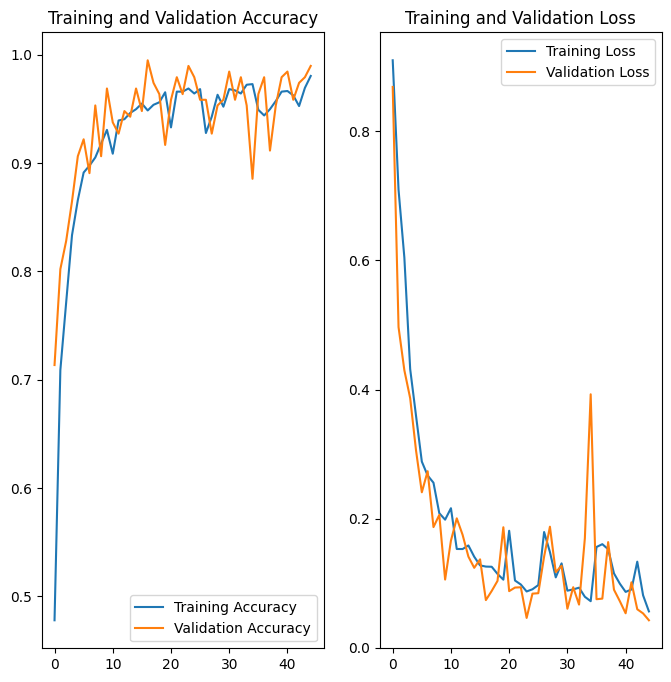

In [29]:
plt.figure(figsize=(8, 8))
plt.subplot (1, 2, 1)
plt.plot(range(EPOCHS),acc, label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc, label = 'Validation Accuracy')
plt.legend (loc="lower right")
plt.title('Training and Validation Accuracy')

plt.subplot (1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend (loc='upper right' )
plt.title( 'Training and Validation Loss')
plt.show